In [1]:
import pandas as pd 
import numpy as np 
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight

In [2]:
# LEER LOS DATOS 
file_in = pd.read_csv('prediction_of_AHE.csv') #lee archivo 
file_in = file_in.drop(['subject_id', 'hadm_id', 'icustay_id'], axis= 'columns') #elimino las columnas que no ocupo 

# IMPUTACIÓN DE DATOS 
x = file_in.drop(['AHE'], axis='columns') #para mis variables de entrada soalamente elimino la varaible a predecir
y= file_in.AHE #me quedo con la variable a predecir en y 
columnas= x.columns 


# DIVIDIR CONJUNTO DE ENTRENAMIENTO, VALIDACIÓN Y PRUEBA 
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.3, )
print('X_train:', x_train.shape, 'X_test:', x_test.shape) 

#OPCIONES DE IMPUTACIÓN
#imp = IterativeImputer(max_iter=30).fit(x_train) 
#imp = KNNImputer(n_neighbors=5, weights= 'uniform').fit(x_train) 
imp= SimpleImputer(missing_values=np.nan, strategy='median').fit(x_train) #mean, most frequent, constant 

x_train = imp.transform(x_train)
x_test = imp.transform(x_test)
print('X_train:', x_train.shape, 'X_test:', x_test.shape)

X_train: (14943, 40) X_test: (6405, 40)
X_train: (14943, 40) X_test: (6405, 40)


In [3]:
print(type(x_train))
x_train_imputado = pd.DataFrame(x_train, columns=[columnas]) #convirtiendo el arreglo en dataframe 
x_test_imputado = pd.DataFrame(x_test, columns=[columnas])
x_test_imputado['age'].describe()

<class 'numpy.ndarray'>


,age
count,6405.000000
mean,64.784856
std,16.835518
min,17.000000
25%,54.000000
50%,67.000000
75%,78.000000
max,98.000000


In [4]:
# ESTANDARIZACIÓN DE DATOS 
scaler = StandardScaler().fit(x_train_imputado)
x_train_escalado = scaler.transform(x_train_imputado)
x_test_escalado = scaler.transform(x_test_imputado)

#COLOCAR PRINTS 
print('X_train:', x_train_escalado.shape, 'X_test:', x_test_escalado.shape)

X_train: (14943, 40) X_test: (6405, 40)


In [5]:
# DEFINIR MODELO A UTILIZAR 
modeloXGB = xgb.XGBClassifier(use_label_encoder=False)

#DEFINIR PARÁMETROS A ITERAR
ratio = float(np.sum(y_train == 0)) / np.sum(y_train==1)
                      
parametrosXGB =  {'n_estimators': range(10, 200, 10), "learning_rate": [0.1,0.05], 'max_depth': range(1,10,1),
                  "scale_pos_weight": [ratio]}
parametros = {'learning_rate': [0.05], 'max_depth': [5], 'n_estimators': [90], 'scale_pos_weight': [1.8786361009439414]}
#ENTRENAR GRID SEARCH 
balanced = class_weight.compute_sample_weight('balanced', y_train)
#RKF = RepeatedKFold(n_splits=5, n_repeats=2, random_state=422) #probar los CROSS VALIDATION
#SKF = StratifiedKFold(n_splits=5, shuffle= True, random_state=422)
RSKF = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)

grid = GridSearchCV(estimator= modeloXGB, param_grid= parametros, cv=RSKF, scoring='roc_auc', verbose=2, refit= True)

In [6]:
grid.fit(x_train, y_train, sample_weight = balanced)

Fitting 100 folds for each of 1 candidates, totalling 100 fits
[00:51:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=5, n_estimators=90, scale_pos_weight=1.8786361009439414; total time=   0.5s
[00:51:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=5, n_estimators=90, scale_pos_weight=1.8786361009439414; total time=   0.5s
[00:51:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/le

[CV] END learning_rate=0.05, max_depth=5, n_estimators=90, scale_pos_weight=1.8786361009439414; total time=   0.5s
[00:51:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=5, n_estimators=90, scale_pos_weight=1.8786361009439414; total time=   0.5s
[00:51:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=5, n_estimators=90, scale_pos_weight=1.8786361009439414; total time=   0.5s
[00:51:43] WARNING: C:/Users/Admini

[CV] END learning_rate=0.05, max_depth=5, n_estimators=90, scale_pos_weight=1.8786361009439414; total time=   0.5s
[00:51:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=5, n_estimators=90, scale_pos_weight=1.8786361009439414; total time=   0.5s
[00:51:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=5, n_estimators=90, scale_pos_weight=1.8786361009439414; total time=   0.5s
[00:51:55] WARNING: C:/Users/Admini

[CV] END learning_rate=0.05, max_depth=5, n_estimators=90, scale_pos_weight=1.8786361009439414; total time=   0.5s
[00:52:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=5, n_estimators=90, scale_pos_weight=1.8786361009439414; total time=   0.5s
[00:52:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=5, n_estimators=90, scale_pos_weight=1.8786361009439414; total time=   0.5s
[00:52:06] WARNING: C:/Users/Admini

[CV] END learning_rate=0.05, max_depth=5, n_estimators=90, scale_pos_weight=1.8786361009439414; total time=   0.5s
[00:52:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=5, n_estimators=90, scale_pos_weight=1.8786361009439414; total time=   0.5s
[00:52:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=5, n_estimators=90, scale_pos_weight=1.8786361009439414; total time=   0.5s
[00:52:18] WARNING: C:/Users/Admini

[CV] END learning_rate=0.05, max_depth=5, n_estimators=90, scale_pos_weight=1.8786361009439414; total time=   0.5s
[00:52:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, use_label_

In [7]:
# METRICAS DEL MODELO 
auc_train = grid.best_score_
std_train = grid.cv_results_['std_test_score'][grid.best_index_]
best_params = grid.best_params_
best_estimator = grid.best_estimator_
print("auc:",auc_train)
print("std_validation:",std_train)
print('best parameters:',best_params)
print('best estimator:', best_estimator)

auc: 0.836395393774251
std_validation: 0.008798524208405276
best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 90, 'scale_pos_weight': 1.8786361009439414}
best estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=90, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.8786361009439414,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


In [8]:
import shap
shap.initjs()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


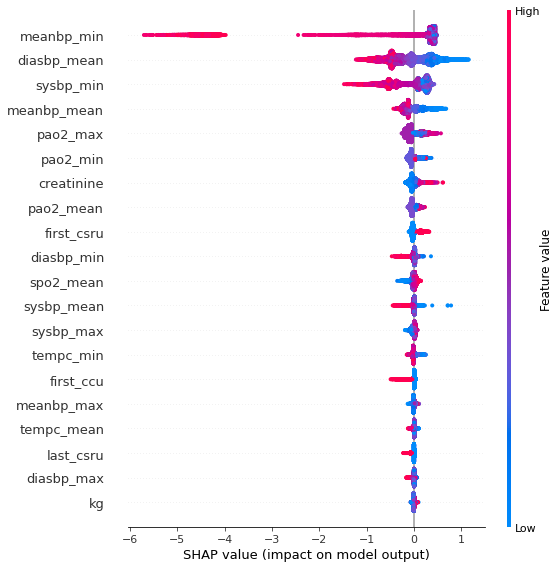

In [9]:
explainer = shap.TreeExplainer(grid.best_estimator_)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values,x_train,
                    feature_names=x.columns,
                    plot_type="dot",
                    max_display=20)

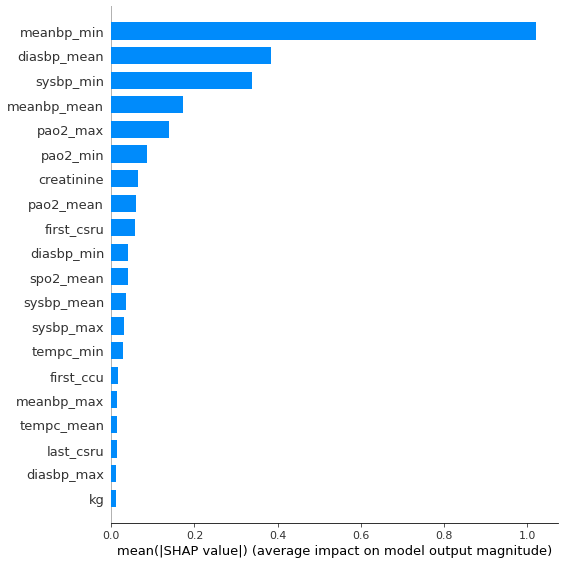

In [10]:
explainer = shap.TreeExplainer(grid.best_estimator_)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train, feature_names=x.columns, plot_type="bar")

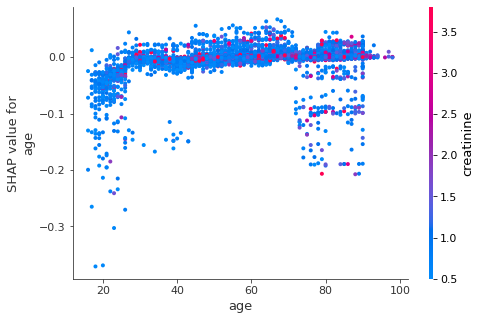

In [11]:
explainer = shap.TreeExplainer(grid.best_estimator_)

shap_values = explainer.shap_values(x_train)
    
feature_list=x.columns.tolist()

shap.dependence_plot(feature_list.index('age'), 
                         shap_values, x_train, 
                         interaction_index=feature_list.index('creatinine'),
                         feature_names=feature_list)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


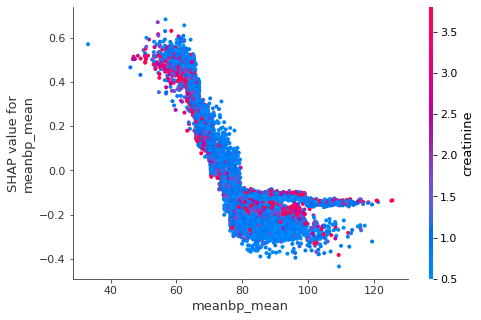

In [12]:
explainer = shap.TreeExplainer(grid.best_estimator_)

shap_values = explainer.shap_values(x_train)
    
feature_list=x.columns.tolist()

shap.dependence_plot(feature_list.index('meanbp_mean'), 
                         shap_values, x_train, 
                         interaction_index=feature_list.index('creatinine'),
                         feature_names=feature_list)